In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from notears.linear import notears_linear
import cdt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [9]:
# Simulate linear SEM with Gaussian noise
def simulate_linear_sem(G, n=1000, noise_scale=1.0):
    d = G.shape[0] # Dimensions of adjacency matrix i.e how many variables there are in the DAG
    X = np.zeros((n, d)) # Create sample matrix where each row (n such rows) is one sample
    
    ordering = list(nx.topological_sort(nx.DiGraph(G)))

    # Samples X column by column (variable by variable according to the topological sort)
    for j in ordering:
        parents = np.where(G[:, j] != 0)[0] # For variable j, look in jth column for arrows pointing into it (parents) and store the parent number (corresponds to the row i in the non zero (i,j) entry)
        if len(parents) > 0:
            X[:, j] = X[:, parents].dot(G[parents, j]) + np.random.normal(scale=noise_scale, size=n)
        else:
            X[:, j] = np.random.normal(scale=noise_scale, size=n)
    return X

# Plotting function
def plot_graph(B, title):
    G = nx.DiGraph(B)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=1500, node_color="lightblue", arrowsize=20)
    plt.title(title)
    plt.show()

# Run NOTEARS on graph and print results
def test_notears(G, n, noise=1.0):
    X = simulate_linear_sem(G, n, noise_scale=noise)

    # Run NOTEARS
    G_est = notears_linear(X, lambda1=0.1, loss_type='l2')

    # Threshold small weights to force adjacency matrix
    G_adj_est = (np.abs(G_est) > 1e-3).astype(int)

    G_graph = nx.DiGraph(G)
    G_est_graph = nx.DiGraph(G_adj_est)

    print("True DAG:\n", G)
    print("Estimated DAG with " + str(n) + " samples:\n", G_adj_est)

    print("Graph Edit Distance (GED) of: " + str(nx.graph_edit_distance(G_graph, G_est_graph)))
    print("Structural Hamming Distance (SHD) of: " + str(cdt.metrics.SHD(G_graph, G_est_graph)))

    plot_graph(G, "True DAG")
    plot_graph(G_adj_est, "Estimated DAG with " + str(n) + " samples")

True DAG:
 [[0 1 1]
 [0 0 1]
 [0 0 0]]
Estimated DAG with 10 samples:
 [[0 0 1]
 [1 0 1]
 [0 0 0]]
Graph Edit Distance (GED) of: 0.0
Structural Hamming Distance (SHD) of: 2


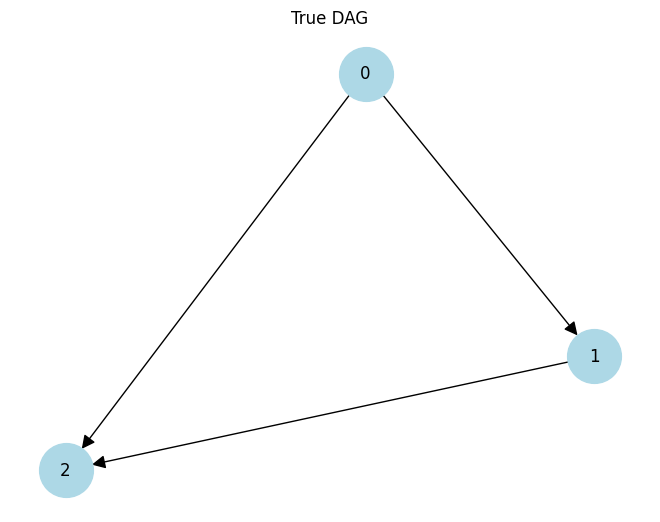

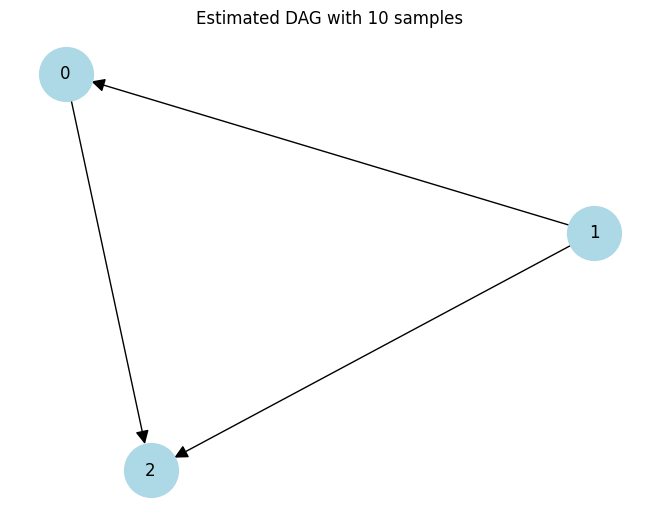

True DAG:
 [[0 1 1]
 [0 0 1]
 [0 0 0]]
Estimated DAG with 2000 samples:
 [[0 1 1]
 [0 0 1]
 [0 0 0]]
Graph Edit Distance (GED) of: 0.0
Structural Hamming Distance (SHD) of: 0


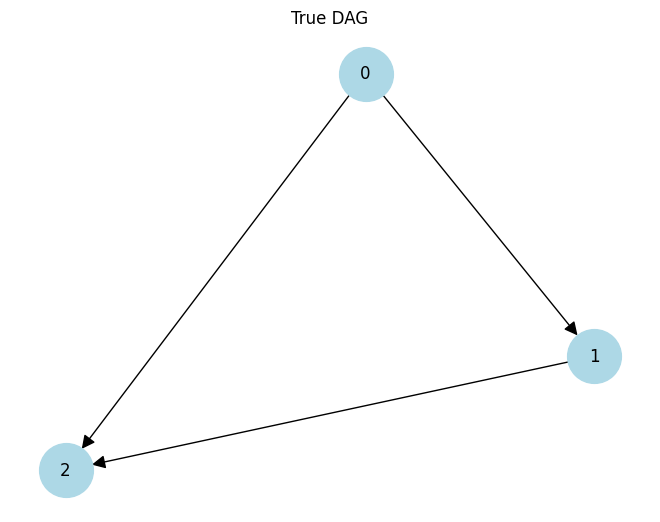

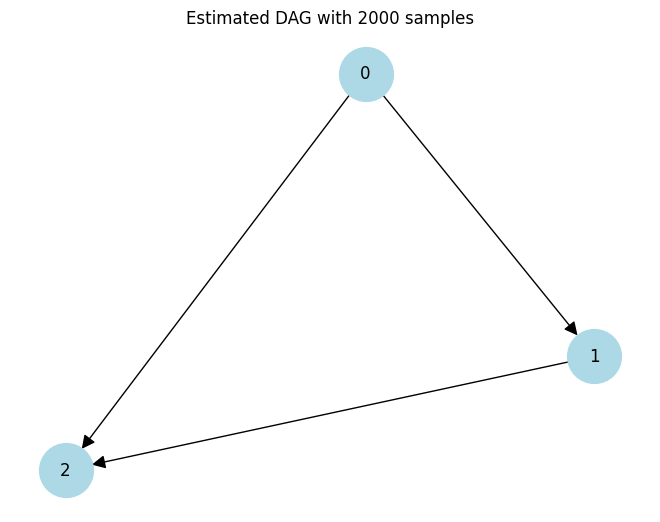

In [8]:
# X1 -> X2 -> X3, and X1 -> X3
test_graph = np.array([[0, 1, 1],
                   [0, 0, 1],
                   [0, 0, 0]])
test_notears(test_graph, 10, 3.0)
test_notears(test_graph, 2000, 3.0)